In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pycocotools import mask as mask_utils
import json
import numpy as np
import glob
import os

In [101]:
def generate_data(path):
    data_map = []
    if not path.endswith("/"):
        path += "/"
    for sub_dir_path in glob.glob(path + "*"):
        if os.path.isdir(sub_dir_path):
            dirname = sub_dir_path.split("/")[-1]
            for filename in os.listdir(sub_dir_path):
                image_path = sub_dir_path + "/" + filename
                data_map.extend([dirname, image_path])

    images = sorted([p for p in data_map[1::2] if "mask" not in p])
    masks = sorted([p for p in data_map[1::2] if "mask" in p])
    return images, masks


def generate_mask_bbox(mask_file) -> (dict, list):
    mask_array = np.array(Image.open(mask_file))
    rle = mask_utils.encode(np.asfortranarray(mask_array.astype(np.uint8)))
    rle["counts"] = rle["counts"].decode("utf-8")  # Convert bytes to string

    # Get the non-zero pixel coordinates
    y_indices, x_indices = np.nonzero(mask_array)

    # Check if there are any non-zero pixels
    if y_indices.size > 0 and x_indices.size > 0:
        # If there are non-zero pixels, calculate the bounding box
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    else:
        # If there are no non-zero pixels, return an empty bounding box
        bbox = None

    return rle, bbox

In [88]:
path = "/home/emanuele/LabelAnything/data/raw/lgg-mri-segmentation/kaggle_3m"
images, masks = generate_data(path)
print(len(images), len(masks))

3929 3929


In [95]:
data_dict = {
    "info": {
        "description": "Brain MRI Dataset Annotations files",
        "version": "1.0",
        "year": 2024,
        "contributor": "CILAB",
        "date_created": "07/02/2024",
    },
    "images": [
        # {
        #     "file_name": "2007_000032",
        #     "url": "VOC2012/JPEGImages/2007_000032.jpg",
        #     "height": 281,
        #     "width": 500,
        #     "id": 0,
        # },
        # {...},
    ],
    "annotations": [
        # {
        #     "segmentation": [
        #         [
        #             rle_mask['counts']
        #         ]
        #     ],
        #     "area": 20098.5,
        #     "image_id": 40,
        #     "bbox": [118.0, 176.0, 330.0, 277.0],
        #     "category_id": 9,
        #     "id": 64,
        # },
        # {...},
    ],
    "categories": [
        # {"id": 0, "name": "sheep"},
        # {"id": 1, "name": "bird"},
        # {"id": 2, "name": "bus"},
        # {"id": 3, "name": "cow"},
    ],
}

In [102]:
images, masks = generate_data(path)

In [115]:
def generate_annotations(images, masks, annotations):
    annotations_images = []
    annotations_segmentations = []

    for idx, (image, mask) in enumerate(zip(images, masks)):
        image_name = image.split("/")[-1].split(".")[0]
        annotations_images.append(
            {
                "file_name": image_name,
                "url": image,
                "height": Image.open(image).size[1],
                "width": Image.open(image).size[0],
                "id": idx,
            }
        )

        rle, bbox = generate_mask_bbox(mask)
        if bbox is None:
            category_id = 0
        else:
            category_id = 1
        annotations_segmentations.append(
            {
                "segmentation": rle["counts"],
                "area": int(mask_utils.area(rle)),
                "image_id": idx,
                "bbox": bbox,
                "category_id": category_id,
                "id": idx,
            }
        )

    annotations["images"] = annotations_images
    annotations["annotations"] = annotations_segmentations
    annotations["categories"] = [
        {"id": 0, "name": "no_tumor"},
        {"id": 1, "name": "tumor"},
    ]

    return annotations

In [116]:
annotations = generate_annotations(images, masks, data_dict)

In [117]:
with open("instances_brain_mri.json", "w") as f:
    json.dump(annotations, f)

TypeError: Object of type int64 is not JSON serializable

In [45]:
from matplotlib import pyplot as plt

image_path = "/home/emanuele/LabelAnything/data/raw/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif"
mask_path = "/home/emanuele/LabelAnything/data/raw/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_mask.tif"


def generate_mask_bbox(mask_file) -> (dict, list):
    mask_array = np.array(Image.open(mask_file))
    rle = mask_utils.encode(np.asfortranarray(mask_array.astype(np.uint8)))
    rle["counts"] = rle["counts"].decode("utf-8")  # Convert bytes to string

    # Get the bounding box coordinates
    y_indices, x_indices = np.nonzero(mask_array)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    return rle, [x_min, y_min, x_max - x_min, y_max - y_min]

In [46]:
rle_mask, bbox = generate_mask_bbox(mask_path)

In [8]:
# Assuming 'rle_mask' is your RLE mask
binary_mask = mask_utils.decode(rle)

plt.imshow(binary_mask, cmap="gray")
plt.show()

TypeError: string indices must be integers

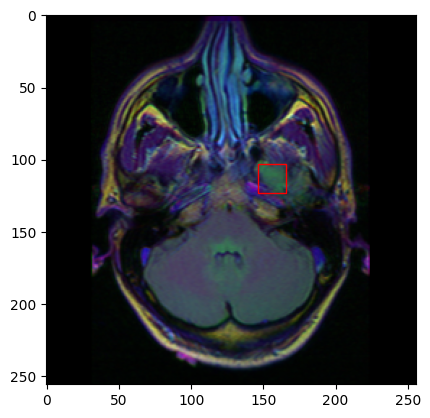

In [49]:
import matplotlib.patches as patches

fix, ax = plt.subplots(1)
ax.imshow(np.array(Image.open(image_path)))

rect = patches.Rectangle(
    (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)
plt.show()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):

        self.df = pd.read_csv(df)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx, 1]
        mask = self.df.iloc[idx, 2]

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return image, mask

        # unnormilize mask
        # mask = torch.clamp(mask.float(), min=0, max=1)
        # mask = torch.ceil(mask)

In [15]:
dataset = BrainMriDataset(
    "/home/emanuele/LabelAnything/data/processed/df.csv", transforms=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [21]:
image, mask = next(iter(dataloader))

In [22]:
image, mask

(('data/raw/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_10.tif',),
 ('data/raw/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_10_mask.tif',))